In [ ]:
!pip install sagemaker==1.72.0 

In [246]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import Audio
sound_file = './sound/beep.wav'

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

<h2> Data Processing </h2>

ROI is calculated using next price because we are trying to predict future ROI using the data from current time period.
Referred to https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb

In [247]:
DATA_DIR = './data'

In [248]:
data.sort_values(by='time', inplace=True)
data.reset_index(drop=True)

data = pd.read_csv(os.path.join(DATA_DIR, 'crypto-historical-data.csv'), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

data['market_share'] = data.groupby('time')["market_cap"] \
                    .apply(lambda x: x/float(x.sum()))

data['age'] = data.groupby(['sym'])["time"] \
                    .apply(lambda x: x - min(x)) \
                    .dt.days

next_price = data.groupby(['sym'])['price'].shift(-1)
data['roi'] = next_price/data['price'] - 1

In [249]:
data.head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
0,20461600.0,Viberate,0.114889,VIB,2018-04-01,4702470.0,250,0.000078,176,0.086658
1,19204400.0,Viberate,0.124845,VIB,2018-04-02,3688650.0,260,0.000076,177,0.069118
2,20825800.0,Viberate,0.133474,VIB,2018-04-03,3681530.0,253,0.000079,178,-0.087800
3,22260000.0,Viberate,0.121755,VIB,2018-04-04,5583970.0,250,0.000079,179,-0.028278
4,20086900.0,Viberate,0.118312,VIB,2018-04-05,2824800.0,251,0.000079,180,-0.016727
5,19692900.0,Viberate,0.116333,VIB,2018-04-06,2941990.0,257,0.000077,181,0.062665
6,19452600.0,Viberate,0.123623,VIB,2018-04-07,2648150.0,256,0.000078,182,0.027988
7,20606400.0,Viberate,0.127083,VIB,2018-04-08,4403120.0,257,0.000080,183,-0.015588
8,21145500.0,Viberate,0.125102,VIB,2018-04-09,4402010.0,257,0.000080,184,0.065403
9,21131200.0,Viberate,0.133284,VIB,2018-04-10,4475740.0,257,0.000082,185,0.081600


<h2> Data Selection </h2>

In [250]:
filtered = data.query('volume > 100000')
filtered = filtered.query('sym == "BTC"')

In [251]:
filtered.sort_values(by='time')

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
118368,9.295570e+09,Bitcoin,735.07,BTC,2013-12-27,4.686270e+07,1,0.880437,243,-0.570299
118373,8.990850e+09,Bitcoin,727.83,BTC,2013-12-28,3.250580e+07,1,0.880399,244,-0.564129
118378,8.872600e+09,Bitcoin,745.05,BTC,2013-12-29,1.901130e+07,1,0.881433,245,-0.580337
118383,9.037000e+09,Bitcoin,756.13,BTC,2013-12-30,2.070770e+07,1,0.879989,246,-0.589039
118388,9.268240e+09,Bitcoin,754.01,BTC,2013-12-31,2.089730e+07,1,0.879546,247,-0.575350
...,...,...,...,...,...,...,...,...,...,...
117987,1.173920e+11,Bitcoin,7023.52,BTC,2018-04-08,3.652500e+09,1,0.454923,1806,-0.936965
117992,1.195160e+11,Bitcoin,6770.73,BTC,2018-04-09,4.894060e+09,1,0.451838,1807,-0.946065
117997,1.153060e+11,Bitcoin,6834.76,BTC,2018-04-10,4.272750e+09,1,0.446148,1808,-0.938410
118002,1.161260e+11,Bitcoin,6968.32,BTC,2018-04-11,4.641890e+09,1,0.441747,1809,-0.939566


<h2> Feature Engineering </h2>

In [252]:
feat = filtered.copy()

In [253]:
W = 3
TARGET = 'price'

In [254]:
properties = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']
feat_columns = []

for p in properties:
    if p != TARGET:
        feat_columns.append(p)
        
        for w in range(1, W+1):
            col_name = "{}_lag_{}".format(p, w)
            feat[col_name] = feat.groupby(['sym'])[p].shift(w)
            feat_columns.append(col_name)
    
    feat[p + '_mean'] = feat[p].shift(1).rolling(w, min_periods=1).mean()
    feat[p + '_std'] = feat[p].shift(1).rolling(w, min_periods=1).std()
    print(p, len(feat.columns))

feat.dropna(inplace=True)

market_cap 15
price 17
volume 22
rank 27
market_share 32
age 37
roi 42


In [255]:
feat.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
117951,1.741300e+10,Bitcoin,1080.50,BTC,2017-04-01,2.896340e+08,1,0.676624,1434,5.334317,...,1069.0,703.0,338.0,703.333333,365.500114,1.585176,0.690298,-0.483110,0.597455,1.037264
117952,1.187050e+11,Bitcoin,6844.23,BTC,2018-04-01,4.532100e+09,1,0.453257,1799,-0.936130,...,1434.0,1069.0,703.0,1068.666667,365.500114,5.334317,1.585176,0.690298,2.536597,2.463865
117953,6.032970e+09,Bitcoin,437.14,BTC,2014-04-02,4.964760e+07,1,0.900557,339,-0.421238,...,1799.0,1434.0,1069.0,1434.000000,365.000000,-0.936130,5.334317,1.585176,1.994454,3.155196
117954,3.461060e+09,Bitcoin,253.00,BTC,2015-04-02,2.627260e+07,1,0.882241,704,0.663518,...,339.0,1799.0,1434.0,1190.666667,759.808090,-0.421238,-0.936130,5.334317,1.325650,3.481141
117955,6.436700e+09,Bitcoin,420.87,BTC,2016-04-02,4.568120e+07,1,0.793178,1070,1.618790,...,704.0,339.0,1799.0,947.333333,759.808090,0.663518,-0.421238,-0.936130,-0.231283,0.816566


<h2> Data Split </h2>

In [256]:
VAL_START = pd.Timestamp('2017-04-25')
TEST_START = pd.Timestamp('2017-10-25')

In [257]:
train = feat.query("time < @VAL_START")
val = feat.query("time >= @VAL_START & time <= @TEST_START")
trainval = feat.query("time <= @TEST_START")
test = feat.query("time >= @TEST_START")

In [258]:
cols_to_scale = feat_columns + [TARGET]

In [259]:
scaler_train = StandardScaler()
train_cols_scaled = scaler_train.fit_transform(train[cols_to_scale])
train_scaled = train.copy()
train_scaled[cols_to_scale] = train_cols_scaled

In [260]:
train_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
count,1.212000e+03,1.212000e+03,1.212000e+03,1212.0,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03,1.212000e+03,...,1.212000e+03,1.212000e+03,1.212000e+03,1212.000000,1212.000000,1.212000e+03,1.212000e+03,1.212000e+03,1212.000000,1212.000000
mean,4.625929e-17,1.611289e-16,-7.099198e-18,0.0,-2.593818e-15,-1.007628e-17,-1.162436e-16,-3.169449e-17,7.932782e-17,-6.508362e-17,...,-2.548841e-17,-1.392359e-17,3.297692e-17,1062.257701,516.336856,-4.763333e-18,-1.509610e-16,5.981647e-17,1.378768,3.089648
std,1.000413e+00,1.000413e+00,1.000413e+00,0.0,1.000413e+00,1.000413e+00,1.000413e+00,1.000413e+00,1.000413e+00,1.000413e+00,...,1.000413e+00,1.000413e+00,1.000413e+00,196.374954,142.509877,1.000413e+00,1.000413e+00,1.000413e+00,1.639308,2.624227
min,-1.257324e+00,-1.348981e+00,-7.755814e-01,0.0,-4.001754e+00,-1.731445e+00,-8.063257e-01,-5.436999e-01,-5.865016e-01,-5.723729e-01,...,-1.458253e+00,-1.620631e+00,-2.230204e+00,608.000000,365.000000,-1.066826e+00,-6.425977e-01,-7.606821e-01,-0.395690,0.658926
25%,-7.898619e-01,-8.042161e-01,-5.708253e-01,0.0,-6.021487e-01,-8.655273e-01,-6.899417e-01,-5.134326e-01,-5.186367e-01,-5.201434e-01,...,-8.372041e-01,-1.019815e+00,-6.471405e-01,936.583333,365.500114,-1.000251e+00,-6.274831e-01,-7.450789e-01,0.064951,1.151054
50%,-2.579779e-01,-2.663008e-01,-3.211931e-01,0.0,1.251302e-01,3.904503e-04,-3.126230e-01,-4.790745e-01,-4.615981e-01,-4.577348e-01,...,-2.161548e-01,2.772536e-01,8.262359e-02,1085.000000,557.546710,-5.380015e-01,-5.225392e-01,-2.391662e-01,0.754520,2.028596
75%,5.090363e-01,4.943796e-01,1.015058e-01,0.0,8.140274e-01,8.663082e-01,1.055244e-01,5.232968e-02,1.886245e-02,2.193713e-02,...,1.124596e+00,8.780690e-01,8.147982e-01,1186.416667,557.546710,9.239753e-01,2.503319e-01,1.611156e-01,2.221619,4.320856
max,3.216799e+00,3.044993e+00,7.790942e+00,0.0,1.736209e+00,1.729375e+00,5.230593e+00,4.591666e+00,4.629291e+00,4.624798e+00,...,1.745645e+00,1.478884e+00,1.546973e+00,1445.000000,759.808090,2.102270e+00,5.020678e+00,5.085686e+00,7.866876,13.937108


<h2> Data Scaling </h2>

In [261]:
scaler_trainval = StandardScaler()
trainval_cols_scaled = scaler_trainval.fit_transform(trainval[cols_to_scale])
trainval_scaled = trainval.copy()
trainval_scaled[cols_to_scale] = trainval_cols_scaled

In [262]:
def scale_col(df, base, col):
    mean = df[base+'_mean']
    std = df[base+'_std']
    std = np.where(std == 0, 0.001, std)
    return (df[col] - mean)/std

In [263]:
val_scaled = val.copy()
for p in properties:
    val_scaled[p] = scale_col(val_scaled, p, p)
    
    if p != TARGET:
        for w in range(1, W+1):
            col_name = "{}_lag_{}".format(p, w)
            val_scaled[col_name] = scale_col(val_scaled, p, col_name)

In [264]:
test_scaled = test.copy()
for p in properties:
    test_scaled[p] = scale_col(test_scaled, p, p)
    
    if p != TARGET:
        for w in range(1, W+1):
            col_name = "{}_lag_{}".format(p, w)
            test_scaled[col_name] = scale_col(test_scaled, p, col_name)

In [265]:
test_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
count,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,170.000000
mean,31.256755,32.073609,167.887753,0.0,-11.792025,1.998857,-0.987894,1.134634,-0.409815,-0.724820,...,1.000225,-0.000451,-0.999774,994.917647,3.655001e+02,1.144951,-0.463632,-0.681319,4.134895,5.652431
std,15.160972,16.392300,165.658151,0.0,9.225115,0.000398,0.229655,0.014741,0.104236,0.091245,...,0.000398,0.000795,0.000398,49.328413,1.971103e-12,0.010917,0.075278,0.064877,1.415862,2.704174
min,12.401877,12.177082,10.967319,0.0,-53.574841,1.998175,-1.649234,1.070766,-0.683101,-0.909675,...,0.999544,-0.000912,-1.000456,910.333333,3.655001e+02,1.105245,-0.607429,-0.842148,2.353910,2.035761
25%,20.112691,19.870677,47.316904,0.0,-12.605008,1.998403,-1.128102,1.128527,-0.441619,-0.775972,...,0.999772,-0.000912,-1.000228,952.583333,3.655001e+02,1.142098,-0.520440,-0.718387,3.123981,3.770771
50%,28.188471,28.690218,125.989203,0.0,-8.929211,1.999087,-0.914710,1.134607,-0.381563,-0.753045,...,1.000456,-0.000912,-0.999544,994.833333,3.655001e+02,1.149012,-0.475401,-0.673611,3.516554,4.873602
75%,39.420433,40.634819,229.328319,0.0,-6.266959,1.999087,-0.807384,1.144782,-0.352554,-0.703163,...,1.000456,0.000456,-0.999544,1037.333333,3.655001e+02,1.152888,-0.423712,-0.632448,4.935479,7.242436
max,75.876868,80.320308,1207.989006,0.0,-2.707939,1.999087,-0.690611,1.154684,-0.161091,-0.464694,...,1.000456,0.000912,-0.999544,1079.666667,3.655001e+02,1.154700,-0.263097,-0.546740,8.318870,13.442992


In [266]:
test_scaled.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_lag_1,age_lag_2,age_lag_3,age_mean,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_mean,roi_std
117952,14.876364,Bitcoin,14.227852,BTC,2018-04-01,30.105434,0.0,-3.223226,1.998175,-1.409463,...,0.999544,0.000912,-1.000456,1068.666667,365.500114,1.135501,-0.386150,-0.749351,2.536597,2.463865
117957,14.383318,Bitcoin,14.435464,BTC,2018-04-02,14.978576,0.0,-3.137387,1.998175,-1.391576,...,0.999544,0.000912,-1.000456,1069.666667,365.500114,1.133773,-0.377363,-0.756410,2.569816,2.520190
117962,14.623107,Bitcoin,14.486036,BTC,2018-04-03,16.646151,0.0,-2.707939,1.998175,-1.396257,...,0.999544,0.000912,-1.000456,1070.666667,365.500114,1.129505,-0.356992,-0.772513,2.630399,2.557105
117967,14.639524,Bitcoin,13.386123,BTC,2018-04-04,20.342826,0.0,-3.645560,1.998175,-1.481345,...,0.999544,0.000912,-1.000456,1071.666667,365.500114,1.125360,-0.338685,-0.786675,2.466040,2.294297
117972,13.529766,Bitcoin,13.523208,BTC,2018-04-05,25.198218,0.0,-3.400044,1.998175,-1.456924,...,0.999544,0.000912,-1.000456,1072.666667,365.500114,1.126105,-0.341884,-0.784221,2.445183,2.318293


In [267]:
train_X = train_scaled[feat_columns]
train_Y = train_scaled[[TARGET]]

trainval_X = trainval_scaled[feat_columns]
trainval_Y = trainval_scaled[[TARGET]]

val_X = val_scaled[feat_columns]
val_Y = val_scaled[[TARGET]]

test_X = test_scaled[feat_columns]
test_Y = test_scaled[[TARGET]]

<h2> Training </h2>

In [268]:
prefix = 'xgboost-new'

pd.concat([train_Y, train_X], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([val_Y, val_X], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)

train_input = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
val_input = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [197]:
container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=0.1,
                        min_child_weight=10,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=20,
                        num_round=200)

xgb.fit({'train': train_input, 'validation': val_input})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-01-30 13:55:19 Starting - Starting the training job...
2021-01-30 13:55:22 Starting - Launching requested ML instances......
2021-01-30 13:56:25 Starting - Preparing the instances for training......
2021-01-30 13:57:21 Downloading - Downloading input data...
2021-01-30 13:58:20 Training - Training image download completed. Training in progress.
2021-01-30 13:58:20 Uploading - Uploading generated training model.Arguments: train
[2021-01-30:13:58:15:INFO] Running standalone xgboost training.
[2021-01-30:13:58:15:INFO] File size need to be processed in the node: 0.57mb. Available memory size in the node: 8451.29mb
[2021-01-30:13:58:15:INFO] Determined delimiter of CSV input is ','
[13:58:15] S3DistributionType set as FullyReplicated
[13:58:15] 1212x24 matrix with 29088 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-01-30:13:58:15:INFO] Determined delimiter of CSV input is ','
[13:58:15] S3DistributionType set as FullyReplicated
[13:58:15] 183

In [198]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [241]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(train_X.values, 200)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = [val for sublist in pred_Y for val in sublist]

In [ ]:
pred_mean = test_scaled[TARGET+'_mean']
pred_std = test_scaled[TARGET+'_std']
pred = (pred_Y * pred_std) + pred_mean

In [ ]:
test_result = test.copy()
test_result['pred'] = pred

In [ ]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
get_mape(test_result[TARGET], test_result['pred'])

In [ ]:
plt.figure(figsize=(10,5))

test_result[test_result['sym'] == 'BTC']['pred'].plot(label='Prediction', lw=1)
test_result[test_result['sym'] == 'BTC'][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [242]:
pred_mean = train_scaled[TARGET+'_mean']
pred_std = train_scaled[TARGET+'_std']
pred = (pred_Y * pred_std) + pred_mean

In [243]:
train_result = train.copy()
train_result['pred'] = pred
train_result = train_result.set_index('time')

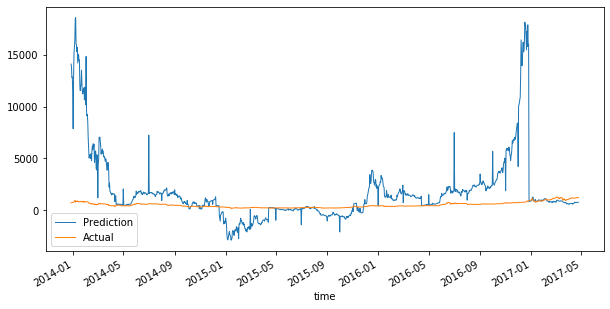

In [244]:
plt.figure(figsize=(10,5))

train_result[train_result['sym'] == 'BTC']['pred'].plot(label='Prediction', lw=1)
train_result[train_result['sym'] == 'BTC'][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [171]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:937637726599:endpoint/xgboost-2021-01-30-13-23-51-400".